In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime

repo_dir = os.getcwd() + '/repo'
tft_dir = os.path.join(repo_dir, 'tft')
os.chdir(tft_dir)

import warnings  
warnings.filterwarnings('ignore')

In [4]:
!ls

data_formatters			       README.md
expt_settings			       repo
libs				       requirements.txt
output_folder			       run.sh
outputs				       script_download_data.py
outputs_pm2.5			       script_hyperparam_opt.py
outputs_stock			       script_train_fixed_params.py
PRSA_data_2010.1.1-2014.12.31 (1).csv  stock.csv
PRSA_data_2010.1.1-2014.12.31.csv      tft_data.csv
__pycache__


In [2]:
output_folder = os.path.join(os.getcwd(), 'outputs_pm2.5')   # Root folder to save experiment outputs
force_download = False 
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
df = pd.read_csv('PRSA_data_2010.1.1-2014.12.31.csv', index_col=0)

In [3]:
df = df.fillna(0)
df['id'] = 0
date_list = list()
for i in range(len(df)):
    year = df.iloc[i]['year']
    month = df.iloc[i]['month']
    day = df.iloc[i]['day']
    hour = df.iloc[i]['hour']
    date_list.append(datetime(year, month, day, hour))
df.index = date_list
df['loc'] = 'Beijing'
df['date'] = date_list

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43824 entries, 2010-01-01 00:00:00 to 2014-12-31 23:00:00
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   year    43824 non-null  int64         
 1   month   43824 non-null  int64         
 2   day     43824 non-null  int64         
 3   hour    43824 non-null  int64         
 4   pm2.5   43824 non-null  float64       
 5   DEWP    43824 non-null  int64         
 6   TEMP    43824 non-null  float64       
 7   PRES    43824 non-null  float64       
 8   cbwd    43824 non-null  object        
 9   Iws     43824 non-null  float64       
 10  Is      43824 non-null  int64         
 11  Ir      43824 non-null  int64         
 12  id      43824 non-null  int64         
 13  loc     43824 non-null  object        
 14  date    43824 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(8), object(2)
memory usage: 5.3+ MB


In [4]:
df.head()

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,id,loc,date
2010-01-01 00:00:00,2010,1,1,0,0.0,-21,-11.0,1021.0,NW,1.79,0,0,0,Beijing,2010-01-01 00:00:00
2010-01-01 01:00:00,2010,1,1,1,0.0,-21,-12.0,1020.0,NW,4.92,0,0,0,Beijing,2010-01-01 01:00:00
2010-01-01 02:00:00,2010,1,1,2,0.0,-21,-11.0,1019.0,NW,6.71,0,0,0,Beijing,2010-01-01 02:00:00
2010-01-01 03:00:00,2010,1,1,3,0.0,-21,-14.0,1019.0,NW,9.84,0,0,0,Beijing,2010-01-01 03:00:00
2010-01-01 04:00:00,2010,1,1,4,0.0,-20,-12.0,1018.0,NW,12.97,0,0,0,Beijing,2010-01-01 04:00:00


In [5]:
from data_formatters.base import GenericDataFormatter, DataTypes, InputTypes

# View avialable inputs and data types.
print("Available data types:")
for option in DataTypes:
    print(option)

print()
print("Avaialbe input types:")
for option in InputTypes:
    print(option)

Available data types:
DataTypes.REAL_VALUED
DataTypes.CATEGORICAL
DataTypes.DATE

Avaialbe input types:
InputTypes.TARGET
InputTypes.OBSERVED_INPUT
InputTypes.KNOWN_INPUT
InputTypes.STATIC_INPUT
InputTypes.ID
InputTypes.TIME


In [6]:
from libs import utils 
import sklearn.preprocessing
class PMFormatter(GenericDataFormatter):
    _column_definition = [
        ('id', DataTypes.REAL_VALUED, InputTypes.ID),
        ('date', DataTypes.DATE, InputTypes.TIME),
        ('loc', DataTypes.CATEGORICAL, InputTypes.STATIC_INPUT),
        ('year', DataTypes.REAL_VALUED, InputTypes.KNOWN_INPUT),
        ('month', DataTypes.REAL_VALUED, InputTypes.KNOWN_INPUT),
        ('day', DataTypes.REAL_VALUED, InputTypes.KNOWN_INPUT),
        ('hour', DataTypes.REAL_VALUED, InputTypes.KNOWN_INPUT),
        ('DEWP', DataTypes.REAL_VALUED, InputTypes.OBSERVED_INPUT),
        ('TEMP', DataTypes.REAL_VALUED, InputTypes.OBSERVED_INPUT),
        ('PRES', DataTypes.REAL_VALUED, InputTypes.OBSERVED_INPUT),
        ('Iws', DataTypes.REAL_VALUED, InputTypes.OBSERVED_INPUT),
        ('Is', DataTypes.REAL_VALUED, InputTypes.OBSERVED_INPUT),
        ('Ir', DataTypes.REAL_VALUED, InputTypes.OBSERVED_INPUT),
        ('pm2.5', DataTypes.REAL_VALUED, InputTypes.TARGET),
        ('cbwd', DataTypes.CATEGORICAL, InputTypes.OBSERVED_INPUT)
    ]
    
    def __init__(self):
        """initializes formatter"""
        
        self.identifiers = None
        self._real_scalers = None
        self._cat_scalers = None
        self._target_scaler = None
        self._num_classes_per_cat_input = None
    
    def split_data(self, data):
        """
        split data frame into training-validation-test data frames
        
        """
        print('Formatting train-valid-test splits.')
        
        train_start = datetime(2010, 1, 1, 0)
        train_end = datetime(2012, 12, 31, 23)
        train_data = data.loc[train_start:train_end]

        val_start = datetime(2013, 1, 1, 0)
        val_end = datetime(2013, 12, 31, 23)
        val_data = data.loc[val_start:val_end]

        test_start = datetime(2014, 1, 1, 0)
        test_end = datetime(2014, 12, 31 ,23)
        test_data = data.loc[test_start:test_end]
        
        self.set_scalers(train_data)
        
        return (self.transform_inputs(data) for data in [train_data, val_data, test_data])
    
    def set_scalers(self, df):
        """
        Calibrates scalers using the data supplied.
        (제공된 데이터를 사용해서 scaler 교정)

        Args:
          df: Data to use to calibrate scalers.
        """
        print('Setting scalers with training data...')
        
        column_definitions = self.get_column_definition()

        id_column = utils.get_single_col_by_input_type(InputTypes.ID,
                                                       column_definitions)
        target_column = utils.get_single_col_by_input_type(InputTypes.TARGET,
                                                           column_definitions)
        # extract identifiers in case required
#         stock에는 identifier가 현재 따로 필요해보이지 않음(데이터 entity가 한개이기 때문)
#         self.identifiers = list(df[id_column].unique())
        
        # Format real scalers
        real_inputs = utils.extract_cols_from_data_type(
            DataTypes.REAL_VALUED, column_definitions,
            {InputTypes.ID, InputTypes.TIME})
        
        data = df[real_inputs].values
        self._real_scalers = sklearn.preprocessing.StandardScaler().fit(data)
        
        # target데이터를 prediction에 사용
        self._target_scaler = sklearn.preprocessing.StandardScaler().fit(df[[target_column]].values)
        
        categorical_inputs = utils.extract_cols_from_data_type(
            DataTypes.CATEGORICAL, column_definitions,
            {InputTypes.ID, InputTypes.TIME})
        
        categorical_scalers = {}
        num_classes = []
        for col in categorical_inputs:
            srs = df[col].apply(str)
            categorical_scalers[col] = sklearn.preprocessing.LabelEncoder().fit(srs.values)
            num_classes.append(srs.nunique())
        
        # set categorical scaler outputs
        self._cat_scalers = categorical_scalers
        self._num_classes_per_cat_input = num_classes
        
    def transform_inputs(self, df):
        """
        performs feature transformations.
        
        feature engineering, preprocessing and normalization을 포함
        
        Args:
            df - data frame to transform.
            
        Returns:
            Transformed data frame.
        """
        output = df.copy()
        
        if self._real_scalers is None and self._cat_scalers is None:
            raise ValueError('Scalers have not been set!')
        
        column_definitions = self.get_column_definition()
        real_inputs = utils.extract_cols_from_data_type(
            DataTypes.REAL_VALUED, column_definitions,
            {InputTypes.ID, InputTypes.TIME}
        )
        categorical_inputs = utils.extract_cols_from_data_type(
            DataTypes.CATEGORICAL, column_definitions,
            {InputTypes.ID, InputTypes.TIME})
        output[real_inputs] = self._real_scalers.transform(df[real_inputs].values)
        for col in categorical_inputs:
            string_df = df[col].apply(str)
            output[col] = self._cat_scalers[col].transform(string_df)
        return output
    
    def format_predictions(self, predictions):
        output = predictions.copy()
        
        column_names = predictions.columns
        for col in column_names:
            if col not in {'forecast_time', 'identifier'}:
                output[col] = self._target_scaler.inverse_transform(predictions[col])
                
        return output
    
    def get_fixed_params(self):
        fixed_params = {
            'total_time_steps': 36,     # Total width of the Temporal Fusion Decoder
            'num_encoder_steps': 24,    # Length of LSTM decoder (ie. # historical inputs)
            'num_epochs': 100,            # Max number of epochs for training
            'early_stopping_patience': 5, # Early stopping threshold for # iterations with no loss improvement
            'multiprocessing_workers': 5  # Number of multi-processing workers
        }
        
        return fixed_params
    
    def get_default_model_params(self):
        model_params = {
            'dropout_rate': 0.3,
            'hidden_layer_size': 160,
            'learning_rate': 0.01,
            'minibatch_size': 64,
            'max_gradient_norm': 0.01,
            'num_heads': 1,
            'stack_size': 1
        }

        return model_params

In [7]:
data_formatter = PMFormatter()
train, valid, test = data_formatter.split_data(df)
train_samples, valid_samples = data_formatter.get_num_samples_for_calibration(
  )

Formatting train-valid-test splits.
Setting scalers with training data...


In [27]:
test

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,id,loc,date
2014-01-01 00:00:00,3.672282,-1.601021,-1.673906,-1.661325,-0.745513,-1.506509,-0.407498,-0.251449,1,2.235235,-0.076123,-0.142394,0,0,2014-01-01 00:00:00
2014-01-01 01:00:00,3.672282,-1.601021,-1.673906,-1.516862,-0.421908,-1.506509,-0.407498,-0.348152,1,2.311887,-0.076123,-0.142394,0,0,2014-01-01 01:00:00
2014-01-01 02:00:00,3.672282,-1.601021,-1.673906,-1.372399,-0.288003,-1.506509,-0.488111,-0.348152,1,2.388540,-0.076123,-0.142394,0,0,2014-01-01 02:00:00
2014-01-01 03:00:00,3.672282,-1.601021,-1.673906,-1.227936,-0.232209,-1.506509,-0.488111,-0.348152,1,2.422671,-0.076123,-0.142394,0,0,2014-01-01 03:00:00
2014-01-01 04:00:00,3.672282,-1.601021,-1.673906,-1.083473,-0.131780,-1.368937,-0.729951,-0.444854,3,-0.483645,-0.076123,-0.142394,0,0,2014-01-01 04:00:00
2014-01-01 05:00:00,3.672282,-1.601021,-1.673906,-0.939010,0.013285,-1.368937,-0.649337,-0.444854,1,-0.423962,-0.076123,-0.142394,0,0,2014-01-01 05:00:00
2014-01-01 06:00:00,3.672282,-1.601021,-1.673906,-0.794547,0.169508,-1.437723,-0.488111,-0.444854,1,-0.330149,-0.076123,-0.142394,0,0,2014-01-01 06:00:00
2014-01-01 07:00:00,3.672282,-1.601021,-1.673906,-0.650084,-0.176415,-1.437723,-0.488111,-0.348152,1,-0.193814,-0.076123,-0.142394,0,0,2014-01-01 07:00:00
2014-01-01 08:00:00,3.672282,-1.601021,-1.673906,-0.505621,-0.366114,-1.368937,-0.488111,-0.348152,1,-0.083030,-0.076123,-0.142394,0,0,2014-01-01 08:00:00
2014-01-01 09:00:00,3.672282,-1.601021,-1.673906,-0.361158,-0.645084,-1.368937,-0.407498,-0.251449,1,0.010784,-0.076123,-0.142394,0,0,2014-01-01 09:00:00


In [8]:
import libs.hyperparam_opt
import libs.tft_model
import libs.utils as util

ModelClass = libs.tft_model.TemporalFusionTransformer
data_params = data_formatter.get_experiment_params()
param_ranges = ModelClass.get_hyperparm_choices()

In [9]:
model_params = {'dropout_rate': 0.3,      # Dropout discard rate
                'hidden_layer_size': 320, # Internal state size of TFT
                'learning_rate': 0.001,   # ADAM initial learning rate
                'minibatch_size': 128,    # Minibatch size for training
                'max_gradient_norm': 100.,# Max norm for gradient clipping
                'num_heads': 1,           # Number of heads for multi-head attention
                'stack_size': 1           # Number of stacks (default 1 for interpretability)
               }

In [10]:
model_folder = os.path.join(output_folder, 'saved_models', 'pm2.5(v2)', 'fixed')
model_params['model_folder'] = model_folder

model_params.update(data_params)

In [11]:
HyperparamOptManager = libs.hyperparam_opt.HyperparamOptManager
print("*** Loading hyperparm manager ***")
opt_manager = HyperparamOptManager(param_ranges, data_params, model_folder)

*** Loading hyperparm manager ***


In [18]:
success = opt_manager.load_results()
restart_opt = 'yes'
if success and not restart_opt:
    print("Loaded results from previous training")
else:
    print("Creating new hyperparameter optimisation")
    opt_manager.clear()

Loading results from /workspace/inkyung/TFT/repo/tft/outputs_pm2.5/saved_models/pm2.5(v2)/fixed
Creating new hyperparameter optimisation


In [19]:
import tensorflow as tf
from libs.tft_model import TemporalFusionTransformer

# Specify GPU usage
tf_config = utils.get_default_tensorflow_config(tf_device="gpu", gpu_id=2)

Selecting GPU ID=2


In [20]:
tf.compat.v1.get_default_graph()
with tf.Graph().as_default(), tf.compat.v1.Session(config=tf_config) as sess:

    tf.compat.v1.keras.backend.set_session(sess)
    params = opt_manager.get_next_parameters()
    # Create a TFT model
    model = TemporalFusionTransformer(model_params,
                                    use_cudnn=True) # Run model on GPU using CuDNNLSTM cells

    # Sample data into minibatches for training
    if not model.training_data_cached():
        model.cache_batched_data(train, "train", num_samples=train_samples)
        model.cache_batched_data(valid, "valid", num_samples=valid_samples)

    # Train and save model
    model.fit()
    
    val_loss = model.evaluate()
    if np.allclose(val_loss, 0.) or np.isnan(val_loss):
        # Set all invalid losses to infintiy.
        # N.b. val_loss only becomes 0. when the weights are nan.
        print("Skipping bad configuration....")
        val_loss = np.inf
    opt_manager.update_score(params, val_loss, model)
    tf.compat.v1.keras.backend.set_session(sess)
    model.save(model_folder)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla V100-DGXS-32GB, pci bus id: 0000:0e:00.0, compute capability: 7.0

Resetting temp folder...
*** TemporalFusionTransformer params ***
# dropout_rate = 0.3
# hidden_layer_size = 320
# learning_rate = 0.001
# minibatch_size = 128
# max_gradient_norm = 100.0
# num_heads = 1
# stack_size = 1
# model_folder = /workspace/inkyung/TFT/repo/tft/outputs_pm2.5/saved_models/pm2.5(v2)/fixed
# total_time_steps = 36
# num_encoder_steps = 24
# num_epochs = 100
# early_stopping_patience = 5
# multiprocessing_workers = 5
# column_definition = [('id', <DataTypes.REAL_VALUED: 0>, <InputTypes.ID: 4>), ('date', <DataTypes.DATE: 2>, <InputTypes.TIME: 5>), ('year', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('month', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_

Cached data "train" updated
Cached data "valid" updated
*** Fitting TemporalFusionTransformer ***
Getting batched_data
Using cached training data
Using cached validation data
Using keras standard fit
Train on 26269 samples, validate on 8725 samples
Epoch 1/100
26269/26269 [==============================] - ETA: 0s - loss: 0.5286WARNING:tensorflow:From /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
26269/26269 [==============================] - 35s 1ms/sample - loss: 0.5286 - val_loss: 0.4444
Epoch 2/100
26269/26269 [==============================] - 31s 1ms/sample - loss: 0.3891 - val_loss: 0.4230
Epoch 3/100
26269/26269 [==============================] - 31s 1ms/sample - loss: 0.3710 - val_loss: 0.4230
Epoc

In [21]:
tf.compat.v1.reset_default_graph()
with tf.Graph().as_default(), tf.compat.v1.Session(config=tf_config) as sess:
    tf.compat.v1.keras.backend.set_session(sess)
    # Create a new model & load weights
    model = TemporalFusionTransformer(model_params,
                                      use_cudnn=True)
    model.load(model_folder)
    
    # Make forecasts
    output_map = model.predict(test, return_targets=True)
    
    targets = data_formatter.format_predictions(output_map["targets"])
    # Format predictions
    
    p50_forecast = data_formatter.format_predictions(output_map["p50"])
    p90_forecast = data_formatter.format_predictions(output_map["p90"])

    def extract_numerical_data(data):
        """Strips out forecast time and identifier columns."""
        return data[[
            col for col in data.columns
            if col not in {"forecast_time", "identifier"}
        ]]
    # Compute Losses
    p50_loss = utils.numpy_normalised_quantile_loss(
        extract_numerical_data(targets), extract_numerical_data(p50_forecast),
        0.5)
    p90_loss = utils.numpy_normalised_quantile_loss(
        extract_numerical_data(targets), extract_numerical_data(p90_forecast),
        0.9)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla V100-DGXS-32GB, pci bus id: 0000:0e:00.0, compute capability: 7.0

Resetting temp folder...
*** TemporalFusionTransformer params ***
# dropout_rate = 0.3
# hidden_layer_size = 320
# learning_rate = 0.001
# minibatch_size = 128
# max_gradient_norm = 100.0
# num_heads = 1
# stack_size = 1
# model_folder = /workspace/inkyung/TFT/repo/tft/outputs_pm2.5/saved_models/pm2.5(v2)/fixed
# total_time_steps = 36
# num_encoder_steps = 24
# num_epochs = 100
# early_stopping_patience = 5
# multiprocessing_workers = 5
# column_definition = [('id', <DataTypes.REAL_VALUED: 0>, <InputTypes.ID: 4>), ('date', <DataTypes.DATE: 2>, <InputTypes.TIME: 5>), ('year', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('month', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_

Loading model from /workspace/inkyung/TFT/repo/tft/outputs_pm2.5/saved_models/pm2.5(v2)/fixed/TemporalFusionTransformer.ckpt
tensor: TemporalFusionTransformer/dense_11/bias (float32) [1]
[0.]
tensor: TemporalFusionTransformer/dense_11/kernel (float32) [320, 1]
[[-0.06511553]
 [ 0.11969958]
 [ 0.10296747]
 [ 0.03917593]
 [-0.07880337]
 [ 0.03573331]
 [-0.10882147]
 [-0.11814006]
 [ 0.13385819]
 [ 0.133325  ]
 [-0.01934744]
 [-0.02944908]
 [ 0.09317663]
 [ 0.08737697]
 [ 0.01084252]
 [-0.06666501]
 [-0.02290215]
 [-0.04057233]
 [ 0.10786533]
 [ 0.02857766]
 [ 0.03948373]
 [-0.05432729]
 [ 0.10076024]
 [-0.05865479]
 [ 0.12409864]
 [ 0.06101017]
 [ 0.11646222]
 [-0.00470336]
 [ 0.12992959]
 [-0.08560711]
 [ 0.12803628]
 [ 0.028433  ]
 [-0.02979364]
 [ 0.02643929]
 [-0.00925793]
 [-0.04026183]
 [ 0.12019722]
 [ 0.08658297]
 [-0.00242801]
 [ 0.07962358]
 [-0.10139391]
 [-0.01175141]
 [-0.08101849]
 [ 0.00888738]
 [-0.01141578]
 [-0.10008088]
 [-0.13623099]
 [-0.09424122]
 [-0.0552621 ]
 [ 0

[[ 6.01419853e-03 -8.93766712e-03  4.23839614e-02]
 [ 6.38224324e-03 -7.20600039e-02 -2.34368853e-02]
 [ 1.45166963e-02 -8.85357484e-02  7.87912980e-02]
 [ 1.21103488e-01  8.38546455e-02 -5.35213575e-02]
 [ 6.68674533e-04  2.95943394e-02 -1.14388084e-02]
 [ 4.36578505e-02 -1.13941848e-01 -8.48896131e-02]
 [-2.65237745e-02  1.12373441e-01  6.29374385e-02]
 [ 2.78748032e-02  9.63693932e-02 -3.46377604e-02]
 [-2.38758861e-03 -9.27871168e-02 -1.27499491e-01]
 [-2.38276422e-02 -2.37718876e-03  7.05056116e-02]
 [-6.46465793e-02 -3.13231125e-02 -9.14261416e-02]
 [-9.25679803e-02  2.04191133e-02  5.76368682e-02]
 [ 1.14824958e-01  1.15927346e-01  1.38380200e-01]
 [ 1.54475318e-02  8.00350234e-02 -5.26227839e-02]
 [ 2.88214516e-02  3.99528258e-02 -7.94273391e-02]
 [-1.06939234e-01 -1.38384290e-02 -1.37360469e-01]
 [-5.21032698e-03 -1.16144111e-02  6.65060207e-02]
 [-2.02609599e-02  8.71797726e-02  7.90854320e-02]
 [ 9.92533937e-02 -1.07759826e-01  6.40328228e-02]
 [-2.01692916e-02  6.17990494e-

[[-0.0065732  -0.16888231 -0.10524733 ...  0.06392731 -0.05689862
   0.03872296]
 [ 0.0049082   0.0977158   0.06229541 ... -0.02390995 -0.03913332
  -0.0017615 ]
 [ 0.12479088 -0.11969358 -0.07538109 ... -0.01448574  0.06668551
   0.08503392]
 ...
 [-0.02459333  0.00447269  0.11077521 ...  0.07987336  0.03427327
  -0.05654034]
 [ 0.06163117 -0.01950486 -0.01173205 ...  0.03872659 -0.07770015
  -0.0770021 ]
 [-0.06638841 -0.02556749 -0.10517649 ...  0.00991644 -0.05120678
   0.06037644]]
tensor: TemporalFusionTransformer/time_distributed_44/bias (float32) [320]
[-1.19016487e-02 -1.05364539e-03  3.16784084e-02 -3.07111219e-02
  5.95142767e-02  1.57618858e-02  1.52175454e-03 -2.84963213e-02
 -1.21251725e-01 -5.74135706e-02 -8.86652097e-02  3.28255780e-02
 -3.90983075e-02 -7.35185742e-02 -8.18019584e-02 -1.78479210e-01
  2.27128286e-02 -5.91927208e-02  2.30333190e-02 -1.05233520e-01
 -6.39036670e-02 -1.85035076e-02 -1.47370752e-02 -2.67377049e-02
 -9.62289702e-03 -3.55269387e-03 -7.4597574

[[ 0.0710454  -0.03683298  0.09484204 ... -0.00740539 -0.07293231
   0.08251654]
 [ 0.0182624  -0.10413421 -0.0185021  ...  0.08832977  0.0607275
   0.08227178]
 [ 0.07954859 -0.01637985  0.04832327 ... -0.04218235  0.0319511
  -0.05176871]
 ...
 [ 0.07337946 -0.02323056 -0.0538107  ...  0.04394513  0.04086974
   0.00297673]
 [-0.16684225  0.0173519  -0.07574552 ... -0.00717115  0.05154178
  -0.02737267]
 [-0.15144718 -0.07685538  0.0558807  ...  0.09083986 -0.08120714
   0.03184475]]
tensor: TemporalFusionTransformer/time_distributed_83/bias (float32) [320]
[ 1.15800346e-03 -9.13920999e-03 -3.91768059e-03 -2.59019528e-03
  3.49964155e-03 -7.45592639e-03  5.93041349e-03  2.37193853e-02
 -8.21774174e-03 -8.77724215e-03 -1.07266773e-02  1.16958935e-02
 -6.70992769e-03  7.05791684e-03  4.77621285e-03 -6.17341418e-03
  9.54919308e-03 -7.58365216e-03  1.86082849e-03  1.95103884e-02
  1.18870204e-02 -1.00106271e-02 -3.88709269e-02  9.19685513e-03
 -8.75033066e-03  1.01891020e-02 -9.80481319e

INFO:tensorflow:Restoring parameters from /workspace/inkyung/TFT/repo/tft/outputs_pm2.5/saved_models/pm2.5(v2)/fixed/TemporalFusionTransformer.ckpt
Done.


In [30]:
import datetime as dte
print("Hyperparam optimisation completed @ {}".format(dte.datetime.now()))
print("Best validation loss = {}".format(val_loss))
# print("Params:")

# for k in best_params:
#     print(k, " = ", best_params[k])
#     print()
print("Normalised quantile losses: P50={}, P90={}".format(p50_loss.mean(), p90_loss.mean()))

Hyperparam optimisation completed @ 2021-07-04 07:51:44.179721
Best validation loss = 0.521871545810071
Normalised quantile losses: P50=0.40483039682602745, P90=0.25946559317297174


<function matplotlib.pyplot.show(close=None, block=None)>

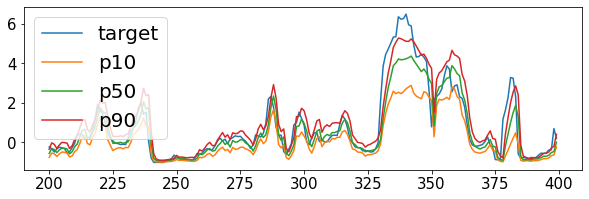

In [31]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 3))
plt.plot(output_map['targets']['t+0'][200:400], label='target')
plt.plot(output_map['p10']['t+0'][200:400], label='p10')
plt.plot(output_map['p50']['t+0'][200:400], label='p50')
plt.plot(output_map['p90']['t+0'][200:400], label='p90')
plt.legend(loc='upper left', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

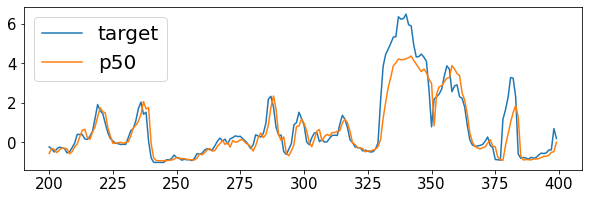

In [32]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 3))
plt.plot(output_map['targets']['t+0'][200:400], label='target')
# plt.plot(output_map['p10']['t+0'][200:400], label='p10')
plt.plot(output_map['p50']['t+0'][200:400], label='p50')
# plt.plot(output_map['p90']['t+0'][200:400], label='p90')
plt.legend(loc='upper left', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

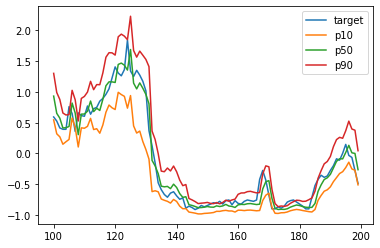

In [24]:
plt.plot(output_map['targets']['t+0'][100:200], label='target')
plt.plot(output_map['p10']['t+0'][100:200], label='p10')
plt.plot(output_map['p50']['t+0'][100:200], label='p50')
plt.plot(output_map['p90']['t+0'][100:200], label='p90')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

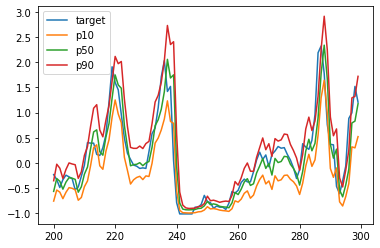

In [25]:
plt.plot(output_map['targets']['t+0'][200:300], label='target')
plt.plot(output_map['p10']['t+0'][200:300], label='p10')
plt.plot(output_map['p50']['t+0'][200:300], label='p50')
plt.plot(output_map['p90']['t+0'][200:300], label='p90')
plt.legend()
plt.show

In [23]:
# Store outputs in maps
counts = 0
interpretability_weights = {k: None for k in ['decoder_self_attn',
                                              'static_flags', 'historical_flags', 'future_flags']}

tf.compat.v1.get_default_graph()
with tf.Graph().as_default(), tf.compat.v1.Session(config=tf_config) as sess:
    
    tf.compat.v1.keras.backend.set_session(sess)
    
    # Create a new model & load weights
    model = TemporalFusionTransformer(model_params,
                                      use_cudnn=True)
    
    model.load(model_folder)
    for identifier, sliced in test.groupby('id'):
        
        print("Getting attention weights for {}".format(identifier))
        weights = model.get_attention(sliced)
        
        for k in interpretability_weights:
            w = weights[k]
            
            # Average attentin across heads if necessary
            if k == 'decoder_self_attn':
                w = w.mean(axis=0)
                
                # Store a single matrix for weights to reduce memory footprint
                batch_size, _, _ = w.shape
                counts += batch_size
            
            if interpretability_weights[k] is None:
                interpretability_weights[k] = w.sum(axis=0)
            else:
                interpretability_weights[k] += w.sum(axis=0)
                
interpretability_weight = {k: interpretability_weights[k]/counts for k in interpretability_weights}

print('Done.')

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla V100-DGXS-32GB, pci bus id: 0000:0e:00.0, compute capability: 7.0

Resetting temp folder...
*** TemporalFusionTransformer params ***
# dropout_rate = 0.3
# hidden_layer_size = 320
# learning_rate = 0.001
# minibatch_size = 128
# max_gradient_norm = 100.0
# num_heads = 1
# stack_size = 1
# model_folder = /workspace/inkyung/TFT/repo/tft/outputs_pm2.5/saved_models/pm2.5(v2)/fixed
# total_time_steps = 36
# num_encoder_steps = 24
# num_epochs = 100
# early_stopping_patience = 5
# multiprocessing_workers = 5
# column_definition = [('id', <DataTypes.REAL_VALUED: 0>, <InputTypes.ID: 4>), ('date', <DataTypes.DATE: 2>, <InputTypes.TIME: 5>), ('year', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('month', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_

time_distributed_60 (TimeDistri (None, 24, 320)      102720      dropout_17[0][0]                 
__________________________________________________________________________________________________
time_distributed_63 (TimeDistri (None, 24, 320)      102720      dropout_18[0][0]                 
__________________________________________________________________________________________________
time_distributed_64 (TimeDistri (None, 24, 320)      102720      dropout_18[0][0]                 
__________________________________________________________________________________________________
activation_5 (Activation)       (None, 320)          0           dense_28[0][0]                   
__________________________________________________________________________________________________
activation_6 (Activation)       (None, 320)          0           dense_32[0][0]                   
__________________________________________________________________________________________________
time_distr

time_distributed_94 (TimeDistri (None, 36, 320)      102720      dropout_29[0][0]                 
__________________________________________________________________________________________________
time_distributed_95 (TimeDistri (None, 36, 320)      102720      dropout_29[0][0]                 
__________________________________________________________________________________________________
multiply_29 (Multiply)          (None, 36, 320)      0           time_distributed_94[0][0]        
                                                                 time_distributed_95[0][0]        
__________________________________________________________________________________________________
add_27 (Add)                    (None, 36, 320)      0           multiply_29[0][0]                
                                                                 layer_normalization_25[0][0]     
__________________________________________________________________________________________________
layer_norm

tensor_name:  TemporalFusionTransformer/dense_16/bias
[ 6.6733980e-03  5.8852076e-03  4.0271427e-03  6.7197741e-03
  7.0529729e-03  2.8688372e-03 -3.7581683e-03  5.9609292e-03
 -5.1001245e-03  7.5593749e-03 -8.2076835e-03  4.5535648e-03
  1.0293898e-03  2.7116893e-03  8.2792267e-03 -4.6630297e-03
  7.2829039e-03  8.5049840e-03 -4.7703842e-03 -7.6247719e-03
 -6.5646940e-03  8.5133258e-03 -2.4440205e-03  8.1849536e-03
  7.5875022e-03 -8.1625180e-03 -5.5296915e-03  5.2111116e-03
 -6.6958587e-03  6.9198315e-03 -2.3363878e-03  5.4479986e-03
  6.6788788e-03 -7.0456425e-03  7.1406607e-03  1.1686333e-03
 -9.4337517e-04  4.2087715e-03  8.7387618e-03 -8.2764532e-03
 -4.5890374e-05 -6.1444971e-03  2.8809621e-03  1.6006606e-03
 -9.0206349e-03 -2.9727363e-03  7.4963793e-03  8.7976297e-03
 -8.9598503e-03 -4.2779003e-03 -8.5159568e-03  2.8033049e-03
 -1.7984285e-03  7.3426180e-03 -6.5716752e-03 -2.6571585e-03
  8.4598461e-04  1.2477282e-03  3.2935874e-04 -7.4931653e-03
  5.3306213e-03 -6.2562334e-03 

tensor_name:  TemporalFusionTransformer/dense_23/bias
[ 8.34557973e-03 -1.06721874e-02  5.76641003e-04  3.55433067e-03
 -4.81802691e-03  5.21322619e-03  5.62771736e-03 -8.37371219e-03
  1.08352937e-02 -4.10669064e-03 -8.90520867e-03 -7.72071769e-03
  1.45413890e-03  7.34578876e-04 -3.51702562e-03 -7.65336072e-03
 -6.33129478e-03  1.48012936e-02 -1.90336129e-03  5.13106911e-03
 -7.92003050e-03 -8.60046968e-03 -5.13949711e-03 -2.13895785e-03
  2.65867403e-03 -1.38557341e-03  6.16914220e-03 -7.56644271e-03
 -4.55450360e-03  4.63429932e-03  1.78467715e-03  1.26797203e-02
 -4.63446230e-03 -1.58738275e-03  2.80874711e-03  2.76148948e-03
  5.75774582e-03  1.62532255e-02  7.69107230e-03  5.66688739e-03
 -1.26463841e-04 -3.35835386e-03 -6.95487531e-03 -1.57149287e-03
 -6.76890463e-03  1.05364081e-02  9.57367534e-04 -1.11323847e-02
 -1.45845357e-02 -2.18301872e-03  7.77322380e-03 -8.94198939e-03
 -4.67995042e-03 -8.14803317e-03  1.23893388e-03 -5.18844789e-03
 -1.13207451e-03  2.30979733e-03 -6.

[[-0.10615605 -0.07633137 -0.00542978 ... -0.04320182 -0.06444576
  -0.00622586]
 [ 0.02694286  0.07653902 -0.0097207  ... -0.0523489  -0.03249099
  -0.03030463]
 [-0.00512574 -0.02325967 -0.05966226 ...  0.06727733 -0.05200129
   0.06106553]
 ...
 [ 0.07256179 -0.08674789 -0.03152158 ...  0.00950626  0.08155016
  -0.04155418]
 [ 0.07355042  0.00880194 -0.06645592 ...  0.02782119 -0.06530203
   0.02255514]
 [ 0.09730709  0.05423165  0.0916261  ...  0.07318413 -0.06054264
  -0.07308521]]
tensor_name:  TemporalFusionTransformer/dense_30/bias
[ 6.43628975e-03 -1.08888717e-02 -1.03891343e-02 -5.37634501e-03
 -2.97466875e-03  3.70536163e-03  3.21307522e-03 -1.79376674e-03
 -4.98960260e-03  2.05120910e-02 -5.91227273e-03 -5.09854080e-03
 -5.32283355e-03 -5.44304494e-03  7.05864746e-03  6.81492593e-03
  6.12924108e-03 -5.72070433e-03 -1.04996320e-02  5.67767653e-04
 -7.96243642e-03 -8.43452662e-03 -7.52691180e-03 -2.20028078e-03
  6.42061699e-03  4.48633777e-03 -6.92595635e-03  6.92834007e-03

[[ 0.00701856 -0.05036348  0.04468612 -0.02436851 -0.01241845  0.01604454
  -0.02259424  0.00854788  0.04133752 -0.01094992 -0.02774606  0.04631928
   0.04266466 -0.02125179  0.01432697  0.02883025  0.02853399 -0.04124599
   0.02218883  0.03120868  0.03413559  0.01359306 -0.00447519  0.00415457
  -0.03481777 -0.03160308  0.00454707 -0.01359917  0.01924647 -0.03196818
  -0.05603129  0.00331532  0.01891948 -0.03407914 -0.03054192  0.01805984
   0.01939328  0.03136841  0.03322136 -0.03479811  0.0226615   0.0282267
   0.04026319  0.00691223 -0.02572532  0.02299558 -0.01678605  0.04064124
  -0.01546481  0.02853868  0.03482956 -0.05329007 -0.04880999  0.00100329
  -0.04643355 -0.01149706 -0.00025918 -0.03875424 -0.02305108 -0.01935709
   0.00101337 -0.03895882  0.04348682  0.04991839  0.02985871  0.01734105
   0.04220471  0.01037024  0.00141432  0.002535    0.03210597 -0.00935252
  -0.01607879 -0.05336904 -0.04721139 -0.04251964  0.02294761  0.00649779
   0.04312186 -0.01764526  0.0472836   

[0.98192483 1.0036783  0.9932104  0.9880853  0.997836   0.9713365
 1.000794   0.98793745 0.9473979  1.0037258  0.98133606 0.97969717
 1.0448054  0.9916858  1.0014627  0.99134296 0.98429    0.97444445
 0.98898137 1.0053041  1.0175354  0.9410582  0.9954018  0.9864768
 0.9953489  0.9423184  0.998993   0.98679745 0.9910681  0.97844034
 0.9693904  0.9774232  0.9907196  0.97721946 0.9115331  0.9892583
 0.98448306 0.9946718  0.96946913 0.9887546  0.9871593  0.99981153
 0.8938994  0.99342084 1.0014813  0.9826737  0.9788401  0.98478144
 0.99371696 0.9624253  0.97618157 0.993853   0.9620504  0.96706676
 0.97560334 0.9249348  0.99317735 0.9683733  0.9502863  0.9483534
 0.93204314 0.99257725 0.99253917 0.9919735  1.0007951  0.9793854
 0.96821976 0.9908268  1.0002366  0.99373937 0.9746623  0.9993127
 0.9611298  0.99580836 0.9806979  0.9967046  0.9703481  0.9973459
 0.9337605  0.9781516  0.99567246 0.99648124 0.9685195  0.9851487
 0.965234   0.93257594 0.9761604  0.9961209  0.9701658  0.984444
 0.97

[1.0038831  1.0815051  0.99027926 0.9981652  1.0231644  0.974825
 1.0108019  0.9746787  1.0322491  0.97472674 0.9462644  1.0321351
 1.0512565  0.9790057  1.0010518  0.9948381  0.994464   0.99993634
 0.9786758  0.9857705  0.990352   1.008817   0.9915622  1.0294353
 0.9903974  0.97309124 0.97320044 0.9910282  1.0283096  0.9846998
 1.0087591  1.0219927  0.9733586  1.0291137  0.9885884  1.073619
 1.030177   1.0244641  0.9952802  0.99690056 1.0331221  0.98917186
 1.0134743  1.0908502  0.99135536 0.99537724 1.0705384  1.0688069
 1.0364949  0.9947402  1.0163659  1.0207235  0.9883995  1.0351602
 1.0436096  0.99115974 0.99486125 0.97457427 0.9863861  0.9924077
 0.9662794  0.9968182  1.0299991  1.0148013  0.99344707 1.0088682
 0.935096   1.0157518  1.0040543  0.93407464 0.9672492  1.0352217
 1.0424736  1.0008411  0.9964695  1.0078535  1.0147406  0.9914308
 0.9852195  1.0382259  1.0448734  1.015312   1.0221559  1.0707617
 0.98516    1.007713   0.9960789  1.1500524  0.9993398  1.0126503
 0.9808447

[1.0097249  0.9943079  1.2221854  1.0085714  1.0071841  0.9214994
 1.0191863  0.8712983  1.1032115  1.0429796  0.9985997  1.075706
 0.99117404 0.99256235 1.0223036  1.0649912  1.083004   0.93608445
 0.93559414 0.97481525 1.1779857  0.9970552  0.9579029  0.9480466
 1.0541754  0.97589266 1.0039384  1.1079379  0.946214   1.1007327
 0.978818   1.1677599  1.0698745  0.9979492  0.99267447 1.04482
 0.97125906 0.9447572  0.99729496 1.0811907  0.99642724 0.9093351
 0.9510441  1.1094756  0.9133071  1.1678044  1.1780939  1.0517635
 1.1065105  0.9743044  0.9658224  1.0676552  1.1859113  1.0134044
 0.98654175 1.1099821  1.021838   0.9291956  0.9410875  0.975615
 0.90509564 0.972531   0.9747835  0.9385556  1.083239   1.093962
 0.92345    0.95082474 1.0300715  0.918234   0.9689928  0.92032504
 1.0601943  1.0943476  0.9620995  0.9558282  0.9488689  0.91544175
 1.0862473  0.97777605 1.1502708  0.9324823  1.0039043  1.1291906
 0.998231   1.043724   0.94672054 1.0545301  1.1073174  0.9787611
 0.9605904  

[ 6.6291415e-03  3.5934767e-03 -4.6438496e-03 -6.2015126e-03
 -5.7015494e-03 -7.9524638e-03  9.3684420e-03 -7.2756032e-03
 -5.2341307e-03 -6.7304117e-03 -7.7096811e-03 -5.1546590e-03
 -4.5497455e-03  4.4633686e-03 -6.3754371e-03 -3.8815569e-04
  4.0297597e-03 -8.0347126e-03 -6.3324803e-03  4.5567523e-03
  4.3963413e-03 -8.3541432e-03  5.7455087e-03  5.4708789e-03
  6.1816396e-03  3.2898018e-03  1.3488032e-02  1.2862902e-03
  2.8080127e-04 -3.6915515e-03  3.6547298e-03 -6.8967617e-03
 -2.1435051e-05  4.3655615e-03 -3.6835724e-03  7.3805386e-03
 -2.7158735e-03  6.9054989e-03 -6.5473776e-04 -5.3144847e-03
 -6.0607796e-03 -7.4077360e-03  3.5504356e-03 -5.9654564e-03
  4.1792090e-03 -4.0475219e-03  2.6449591e-03 -3.2596313e-03
 -2.1197370e-03  6.9757802e-03 -7.1267188e-03 -8.4373765e-03
  7.1749993e-04 -7.0254384e-03 -2.4046402e-03 -1.8847836e-03
 -5.0545027e-03  2.1093730e-03  7.5293453e-03  2.7429340e-03
 -3.7275536e-03 -5.0993948e-03  3.5426677e-03  2.3250284e-03
 -5.4703322e-03  6.78255

[0.9985531  1.0014657  0.97055185 1.0021162  0.96607804 1.0041145
 0.9941006  0.98803896 0.9867103  0.99880654 1.0121893  0.97997993
 0.998855   1.0052241  1.0016026  0.99713206 1.0005884  1.0041138
 0.9820918  1.0012534  0.9906212  1.0023376  0.98821414 0.9886078
 1.0127872  0.99908626 0.9940922  0.99337465 0.99008983 0.9847655
 0.9882623  0.9897259  0.99017805 1.0090306  0.9973189  0.99787456
 0.99647933 1.002505   0.9899747  0.9957011  0.9931467  0.9879276
 0.99007803 0.9930385  1.0076635  0.9578629  0.98334116 0.9820921
 0.99045515 0.9710268  0.9928631  0.9901134  1.0023592  0.9876345
 0.9868801  0.9912317  0.99554455 0.9823864  0.995616   1.0032264
 0.9888981  1.0150723  0.9856735  0.9856556  0.9880588  1.0065587
 0.99092287 0.981549   0.9944396  0.9850583  1.0052389  0.9956061
 0.98501354 0.98950773 0.9884416  1.0077373  0.98558134 0.9985201
 1.0024413  1.0002077  0.99659026 0.9778396  1.0034808  0.9944097
 0.99358946 0.965839   0.9994834  1.0043286  0.9921615  1.0090339
 0.98964

tensor_name:  TemporalFusionTransformer/layer_normalization_28/beta
[ 8.5051293e-03  5.6959204e-03 -5.8523365e-03 -1.7488342e-03
 -5.0795022e-03 -1.8314257e-03  5.6200498e-03 -3.0881232e-03
 -7.0949527e-03 -2.4273398e-03 -9.8312125e-03 -5.8733644e-03
 -7.1360348e-03 -7.8896917e-03 -4.0183601e-05  2.8806303e-03
 -5.6573469e-03 -1.4245461e-03 -4.3119434e-03  4.6627508e-03
  3.6100724e-03  8.1032906e-03  9.0715522e-03  4.0437127e-03
  8.2223788e-03  5.9101321e-03  4.9465243e-03 -2.9528446e-03
  7.0618703e-03 -4.4787261e-03  6.0084076e-03 -5.5799619e-03
  5.7122125e-03 -2.3242359e-03 -3.6937168e-03  6.1663357e-03
 -9.4096473e-04  9.1233673e-03  3.0103920e-03 -5.9670452e-03
 -4.2760670e-03 -5.0053834e-03  4.8576556e-03 -5.3742463e-03
  1.2741038e-02 -2.9067690e-03  8.4006786e-03 -8.4573803e-03
 -5.4924507e-03 -2.4923075e-03 -6.1782999e-03 -3.9293896e-03
  3.8484754e-03 -3.2883638e-03 -6.2459190e-03 -3.0289546e-03
 -5.0839572e-03 -3.0732919e-03  8.1230523e-03  3.1457155e-03
 -3.1936644e-03 -

[0.9939565  0.9852328  0.9465503  0.9963509  1.0028921  1.0087085
 0.9762754  0.98963493 0.96589965 0.9979684  1.0051855  0.9673056
 1.0339704  0.99062127 1.1738709  1.0040485  1.0151793  1.0200677
 0.98557776 0.9957733  1.0145352  1.0039812  0.9608303  0.96832824
 0.9845642  1.0072944  0.9949966  0.98513967 1.077794   0.94069356
 1.0093362  1.0414642  0.98954546 1.065131   1.2181398  1.1351867
 1.0155762  0.98487365 0.96910036 0.999086   0.96763766 1.0161636
 0.97791576 0.96735    0.96528065 1.0047449  1.0115305  1.063607
 0.9822846  0.9166366  0.99723226 1.0020849  1.004206   1.01943
 0.9989655  0.9950092  1.002541   0.99037886 0.9980258  0.95117605
 0.99170256 1.0506972  0.9734269  1.012608   0.9927492  1.0800303
 1.0258579  1.0041833  0.9671486  0.9649673  0.95367813 0.99544895
 0.96060973 1.0025432  0.9961173  0.9812439  0.9324164  0.94085103
 1.0455918  1.0159849  0.98732346 1.021989   1.0030891  0.9822446
 1.0509865  1.0199996  1.0261996  0.9342255  1.0023648  1.0337586
 1.06359

[[-0.04201167 -0.01416922 -0.01086601 ...  0.01141802  0.00515762
   0.14358985]
 [-0.10191599  0.02781735  0.05793828 ... -0.02423241  0.03644839
   0.02357955]
 [ 0.00795095  0.02695559 -0.02767133 ... -0.07029242  0.02506573
   0.07166925]
 ...
 [ 0.04681418  0.00962825 -0.02819216 ... -0.01154385  0.05502874
  -0.02389171]
 [ 0.06647673 -0.08053494 -0.01693282 ...  0.04810634 -0.03201139
   0.00355169]
 [-0.01038819  0.05491673 -0.06384404 ...  0.08536187  0.04186489
  -0.0253922 ]]
tensor_name:  TemporalFusionTransformer/lstm_1/bias
[ 0.00478097  0.00055054 -0.01050952 ... -0.0009722   0.00814866
  0.01739148]
tensor_name:  TemporalFusionTransformer/lstm_1/kernel
[[-0.00705467  0.00477618  0.00720152 ...  0.01568424 -0.01256503
  -0.03338659]
 [-0.0233918  -0.03674387  0.00308399 ...  0.00200635 -0.02294844
   0.00372972]
 [-0.0564218   0.0370019   0.00900079 ...  0.01429093  0.04696566
  -0.03466568]
 ...
 [-0.06737343  0.04302004  0.00547509 ...  0.05719825 -0.09479649
   0.0289

[-9.65618994e-03 -6.35513710e-03 -9.10157431e-03 -1.01532636e-03
 -1.34321181e-02 -4.18157736e-03 -1.43424310e-02 -1.18502567e-03
 -7.25949882e-03 -8.63080285e-03  1.04722809e-02 -2.05030548e-03
 -1.28880581e-02  1.04567204e-02 -1.59791727e-02 -1.12656923e-02
 -9.15967207e-03  1.09451944e-02 -4.88799717e-03 -1.41220791e-02
  6.30955072e-03  1.61488745e-02 -7.35621387e-03 -1.18789554e-04
 -6.82420610e-03 -2.38569118e-02 -1.33219613e-02  9.01808555e-04
 -2.77719018e-03 -6.03429927e-03 -1.14892470e-02 -2.16120901e-03
 -3.91899049e-03 -5.54590672e-03 -9.04993899e-03 -6.43514795e-03
 -1.08101098e-02 -1.40639981e-02 -1.13596190e-02 -1.33078704e-02
  1.13873964e-03 -9.06867348e-03 -9.03898571e-03 -1.16795357e-02
  1.90092307e-02 -5.15932590e-03 -1.01751192e-02 -3.19596438e-04
 -6.86603365e-03 -5.83545072e-03 -1.22301169e-02 -1.14842234e-02
 -1.43054463e-02 -6.65180152e-03 -1.32535854e-02 -1.91484652e-02
 -7.07485992e-03 -5.27849142e-03 -1.18459621e-02 -8.04128498e-03
 -7.77689228e-03  1.02770

[[-0.05301436  0.05635626 -0.05723778 ... -0.01291958  0.11510354
  -0.0014942 ]
 [ 0.08092733  0.05720718 -0.13031259 ... -0.05468702  0.0541878
   0.09370236]
 [-0.11308682 -0.04673263  0.10734467 ...  0.0337708  -0.03433699
  -0.14378996]
 ...
 [-0.14955364 -0.10292923  0.07203478 ...  0.08370664  0.09278832
  -0.03764519]
 [ 0.05517732  0.07714781 -0.0927171  ...  0.09321887 -0.02789103
  -0.09379824]
 [-0.13563362  0.0442442   0.05037657 ...  0.12154017  0.08739329
  -0.01304804]]
tensor_name:  TemporalFusionTransformer/time_distributed_16/bias
[-0.01349381 -0.00482134  0.028172    0.00842122  0.00442534 -0.0234925
  0.02945951  0.0374114   0.01800111 -0.00892955 -0.0105976   0.02494339]
tensor_name:  TemporalFusionTransformer/time_distributed_16/kernel
[[ 0.02166285  0.03170769 -0.03897751 ... -0.14674316 -0.10285182
  -0.08336973]
 [ 0.00836416  0.06775588 -0.0337674  ... -0.02165042 -0.00344241
   0.06400197]
 [-0.11610715  0.06388609 -0.13534829 ...  0.11890787 -0.06162705
   

[-8.39854684e-03  2.23650765e-02  3.51721011e-02  1.43715097e-02
 -2.53895894e-02 -2.23240145e-02  1.45245148e-02  6.58549517e-02
 -1.32524502e-02  1.28937955e-03  3.29661742e-02 -1.00747282e-02
 -5.88462921e-03 -9.35677905e-03  1.74695719e-02  1.01090716e-02
  1.44118313e-02  2.41310280e-02 -2.30286922e-02  1.55574679e-02
 -1.11450045e-03 -6.51151538e-02  4.07115649e-03 -2.43797973e-02
  1.11981742e-02 -9.39153880e-03  5.24339313e-03 -1.85119789e-02
  2.86767073e-02 -2.48085149e-02  2.91841142e-02  9.35194548e-03
 -2.44393304e-04  1.19137187e-02 -3.08040157e-02  7.06351642e-03
 -2.45666094e-02 -3.58635783e-02  1.03605008e-02  3.71279605e-02
  3.94401699e-03 -1.47731528e-02 -4.57383133e-02 -2.27748752e-02
 -1.96168497e-02  1.52897583e-02  2.46445742e-02  8.60257912e-03
 -1.20339626e-02 -2.52425727e-02  1.48177911e-02 -7.08858017e-03
 -2.05670134e-03  7.62331439e-03  1.58683266e-02  4.25756611e-02
  7.98000023e-03 -2.86671985e-02  7.35511491e-03 -2.94657107e-02
  1.17059499e-02 -4.30929

[-5.65826101e-03 -1.69834793e-02  5.21220341e-02  1.58328265e-02
  4.39835116e-02 -6.31930074e-03 -5.48955332e-03 -2.56465636e-02
  1.27405645e-02 -9.68741346e-03 -1.37816379e-02  1.86924580e-02
 -2.75577717e-02 -1.06674887e-03  1.03400936e-02 -5.22765222e-05
  1.62735004e-02  4.82648937e-03 -1.15506933e-04 -3.95838404e-03
  2.60580541e-03 -2.71899980e-02  3.15794302e-03  9.64194629e-03
  6.05408847e-03  2.23001535e-03 -7.86458142e-03  8.73896386e-03
  1.16565060e-02 -1.97045319e-03 -6.18145010e-03 -2.86178174e-03
 -1.26633421e-02  3.56690818e-03 -4.84912889e-03 -2.59990674e-02
 -1.39548602e-02 -3.22879292e-03  2.62120813e-02 -3.09124663e-02
 -5.16918153e-05 -2.07180902e-02 -6.05883310e-03  3.21792532e-03
 -1.35690887e-02 -9.65732499e-04 -2.90157367e-03 -4.33280272e-03
 -2.31958833e-02 -5.55689796e-04  4.34587747e-02 -1.79209169e-02
  2.05735248e-02 -7.63543067e-04 -2.95854337e-03 -1.22346859e-02
  6.28414983e-03  2.27583926e-02 -3.76047343e-02  2.68876348e-02
 -7.46708130e-03  3.72880

 -2.36622849e-03 -3.75470007e-03 -5.96760260e-03 -6.52442779e-03]
tensor_name:  TemporalFusionTransformer/time_distributed_31/kernel
[[ 0.07101026 -0.01879362  0.0084207  ... -0.12741919  0.04966637
  -0.00422217]
 [-0.01265298  0.04975083 -0.09300954 ... -0.03753715 -0.02381977
   0.06255253]
 [-0.00875721 -0.01288096 -0.08241538 ...  0.06548008  0.07505564
  -0.10975892]
 ...
 [ 0.08076998  0.04852023 -0.03014539 ...  0.02246431  0.09943301
   0.02950495]
 [-0.02121408 -0.01390012 -0.05758861 ... -0.07032248  0.05839121
   0.06060383]
 [ 0.08143399  0.01821478  0.02537706 ... -0.0356116  -0.01334053
  -0.00663334]]
tensor_name:  TemporalFusionTransformer/time_distributed_32/bias
[-1.14946477e-02 -1.10103684e-02  1.60825346e-02  5.86269516e-03
 -1.00780483e-02 -5.23047112e-02 -1.15725631e-02 -6.11923598e-02
 -3.37737352e-02  6.01005107e-02 -1.41200200e-02 -1.67914908e-02
  6.56598732e-02 -3.64834853e-02 -3.01001668e-02  2.12108791e-02
 -1.55716296e-02 -2.51928326e-02  1.54585298e-03 -

[-1.07104406e-02 -1.53175713e-02 -1.24659967e-02 -2.05649715e-03
 -2.30347412e-03 -6.64091576e-03 -7.95070082e-04 -8.30814522e-03
 -8.32359958e-03 -1.99535731e-02 -6.60269801e-03  4.39793896e-03
 -9.17474180e-03 -1.31421175e-03  1.60053221e-03  4.57115285e-03
  7.39945099e-03  5.64148766e-04 -7.71759171e-03 -1.45611077e-04
 -1.20928586e-02 -2.40318687e-03 -2.15437189e-02  3.74835706e-03
  1.24902977e-03  8.90576188e-03 -1.29632708e-05  6.52767299e-03
  6.76100794e-03 -4.77038044e-03 -4.44653025e-03 -1.01282466e-02
  3.50985266e-02  1.22253839e-02 -3.43548763e-03 -3.86033184e-03
 -9.60880704e-03  1.46047529e-02  9.50650126e-03  8.69070832e-03
 -3.20032728e-03 -4.25893301e-03 -9.61753726e-03  3.66941863e-03
 -5.01332572e-03 -1.03559392e-02  1.20269954e-02  5.67923307e-05
  5.63485408e-03 -6.86151301e-03  1.14339907e-02 -1.38445070e-03
  1.76868457e-02 -5.84061211e-03 -8.60290416e-03  7.03322887e-03
 -1.76989250e-02  1.14075281e-02 -1.08121214e-02  8.09201784e-03
  7.29545578e-03  1.85108

tensor_name:  TemporalFusionTransformer/time_distributed_42/bias
[ 4.45927726e-03  1.23082781e-02  1.74406357e-02  6.04184344e-04
  1.26346033e-02 -6.44217571e-03 -4.98673739e-03 -6.23233989e-03
 -4.35844585e-02 -7.78768538e-03  5.85252792e-03  8.95628147e-03
  1.83043461e-02 -1.55001720e-02  7.22945249e-03  2.41248943e-02
  8.52210168e-03  8.64225905e-03  3.16550932e-03  1.84449367e-02
 -1.00740558e-02  5.40201645e-03 -2.66338373e-03 -4.04032553e-03
 -3.35052726e-03 -8.88215099e-03  1.75239239e-02 -8.51482339e-03
 -7.32183643e-03 -1.89064573e-02 -5.03184367e-03 -1.10240243e-02
 -9.39781126e-03 -1.77560345e-04 -7.81325158e-03  9.83098801e-03
 -3.10366601e-03  4.75677522e-03 -9.72660445e-03 -9.29981354e-04
 -1.83217763e-03  2.01952774e-02  2.55009555e-03 -1.41593507e-02
 -1.18515156e-02  9.45978449e-04  1.05108414e-02  2.05320194e-02
 -9.61463712e-03  7.37699261e-03 -6.47878647e-03 -3.24540306e-03
  6.22273935e-03 -1.37321383e-03  4.84137039e-04 -3.05956267e-02
 -2.60086656e-02  1.20921

[[ 0.07635529  0.00263536 -0.10489771 ... -0.07783439 -0.07125147
  -0.0044599 ]
 [ 0.01609338 -0.02175867  0.07051884 ... -0.01157105 -0.05159955
   0.02642558]
 [ 0.06377917  0.08385013 -0.01557329 ... -0.07612741  0.03603737
   0.06343765]
 ...
 [ 0.02572902  0.06286102  0.01095512 ...  0.00075413  0.07755695
  -0.05762604]
 [-0.07028206 -0.04794322 -0.08242094 ... -0.06775552  0.08898544
   0.10276492]
 [-0.07157677  0.07335074  0.0911216  ...  0.05344775 -0.07783727
  -0.00869633]]
tensor_name:  TemporalFusionTransformer/time_distributed_47/bias
[ 3.63373896e-03  7.71856308e-03 -1.44654149e-02 -2.63191145e-02
  4.94478131e-03 -1.22358417e-02  6.99897762e-03  2.44843075e-03
  3.88950147e-02  6.99562905e-03 -5.77885483e-04  4.04757308e-03
  1.65267810e-02  9.40290454e-04 -1.40716629e-02 -4.05344553e-03
  7.48779904e-03  1.91915978e-03 -2.53933994e-03 -1.37980497e-02
 -8.76474380e-03 -2.33098911e-03  8.04693322e-04 -4.10935655e-03
  6.25533145e-03  2.24551489e-03 -6.59689447e-03 -1.5

[ 1.12604508e-02  7.89558515e-03 -5.89186326e-03 -1.88921876e-02
  2.65550404e-03 -1.03560323e-02  7.24128308e-03  7.58967781e-03
 -1.55038042e-02  1.99159849e-02  5.18364366e-03  3.73759726e-03
  2.13442463e-02  5.83547261e-03 -1.49428996e-03 -3.01358989e-03
  7.07943738e-03  1.36137912e-02 -9.20884125e-03 -2.79934648e-02
 -6.16779877e-03  2.06610840e-02  1.63002834e-02 -4.76731081e-03
  1.27395643e-02  5.82318241e-03 -8.39042850e-03  5.38764149e-03
  6.02303585e-03  4.43881052e-03 -8.70437175e-03  1.98879465e-02
 -8.62760717e-05  6.78860117e-04  3.74663137e-02  1.58880949e-02
  1.70586922e-04 -5.07737685e-04 -5.54752257e-03  9.94736981e-03
  3.14087584e-03 -1.54536171e-02 -5.93301095e-02 -9.98935383e-03
 -5.08754468e-03  5.64386649e-03  1.07964892e-02  6.03014231e-03
  8.41071270e-03  9.70304571e-03 -3.83009831e-03  1.31002367e-02
 -5.03729694e-02 -1.85184937e-03  3.18202237e-03 -4.70677810e-03
  9.06160288e-03 -1.00916550e-02 -9.81531665e-03 -1.64003018e-02
  1.03030065e-02  6.42747

[[-0.05648577  0.01036676 -0.08594016 ...  0.01622968 -0.04802472
   0.00696503]
 [ 0.01486138 -0.06192228 -0.01830654 ... -0.04601767 -0.02795448
  -0.00761231]
 [-0.01637194 -0.01681342 -0.01894254 ... -0.06471545 -0.05811786
   0.08311816]
 ...
 [ 0.03898811  0.10365438 -0.06475338 ... -0.0944848   0.08884613
   0.03340587]
 [-0.08274348 -0.03829462  0.08258911 ... -0.06050814  0.08583918
  -0.06841865]
 [-0.08726526  0.11863238 -0.05894377 ... -0.00737055  0.17199995
  -0.08226615]]
tensor_name:  TemporalFusionTransformer/time_distributed_58/bias
[ 1.03659676e-02 -6.00786807e-05 -1.19137513e-02  6.12159353e-03
  7.75038544e-03  1.17625482e-03  6.65871846e-03  1.31583298e-02
  7.84186926e-03 -1.53279584e-03  1.27190556e-02  9.54699051e-03
 -1.62219778e-02  1.11423656e-02 -1.39497565e-02  2.19412409e-02
  1.49363681e-04  7.84947909e-03 -1.76876057e-02 -1.33034680e-02
  8.76966678e-03 -1.37094576e-02 -5.23971394e-03  5.22669731e-03
 -9.34777316e-03 -9.00003500e-03 -3.46989394e-03 -1.9

[-0.03454135  0.03932916 -0.02846115  0.01726405 -0.02816131 -0.01974498
 -0.05388611 -0.01370677  0.00968448  0.05180107 -0.01104919 -0.0413005
  0.01684456  0.02226407 -0.03297219 -0.0287595  -0.03690591 -0.01825202
 -0.06542936 -0.00380763  0.04247784  0.00345099  0.03059293 -0.00783928
 -0.00146209 -0.01626542 -0.00576171  0.0263579   0.02219877  0.03707402
  0.02657604  0.03998035 -0.0276436   0.00872364  0.02708541 -0.00339884
  0.03436238  0.02751531 -0.01646797 -0.01284127 -0.04514736  0.03450197
 -0.00941194 -0.02989939  0.02024508 -0.02446565  0.02314524 -0.02992845
 -0.00923737  0.03563669 -0.02600842  0.01170016 -0.01761732 -0.03095343
 -0.02077895 -0.01617558 -0.04011706  0.016138    0.00971975 -0.02992841
 -0.03191197 -0.02701908  0.01940321  0.03044391 -0.04058114 -0.01644155
 -0.01692512 -0.00060969 -0.03581276 -0.04215647 -0.02652329 -0.05003713
  0.03316433  0.03530705 -0.02291156 -0.03557254 -0.02027893  0.01293145
 -0.01792767 -0.00724447  0.02095946 -0.04459776 -0.

[[-1.06704764e-01 -7.78767318e-02 -9.70979780e-03 -1.19927272e-01
  -2.81743947e-02 -1.05252571e-01  4.85532396e-02  5.36596179e-02
  -2.30174307e-02 -4.21528928e-02 -3.92219201e-02  7.69793838e-02
   1.48602184e-02  1.23198688e-01 -1.15118511e-01 -4.43025567e-02
   5.08948416e-03 -7.57538527e-02 -6.10146262e-02 -7.57914484e-02
  -1.19851507e-01  5.33230603e-02 -1.32684842e-01  1.25299945e-01
   1.30754605e-01 -8.80852640e-02 -1.82407275e-02 -4.30352539e-02
   6.97592348e-02 -1.24828614e-01 -7.92736039e-02  1.16679072e-01
   3.96886244e-02  6.65312260e-02  1.79899428e-02 -5.51277734e-02
   1.11896761e-01  7.79461339e-02  4.80319038e-02 -1.03664152e-01
  -8.66859779e-02 -9.17142332e-02 -9.14309770e-02  1.37211725e-01
   9.88475606e-02 -2.42252145e-02  7.69952964e-03 -1.10212164e-02
  -1.36331499e-01  2.02559438e-02 -2.28552204e-02  2.95345578e-02
   1.04727238e-01 -1.23089794e-02 -8.08833260e-03  4.92482074e-02
   8.71718749e-02 -1.07556671e-01 -1.33704096e-01  9.01679620e-02
  -8.28474

[[-0.07528847 -0.01864356 -0.03726449 ... -0.05696012  0.00738605
   0.06469683]
 [-0.06389644 -0.09542567 -0.07650178 ...  0.06541222  0.06341522
   0.06195479]
 [-0.04680467  0.03812923  0.06852949 ... -0.07542511 -0.04541175
  -0.07051544]
 ...
 [-0.06734136 -0.09989475 -0.05344662 ...  0.00501815 -0.02827733
  -0.02198761]
 [ 0.0173506  -0.0012126   0.02363634 ... -0.06749952 -0.0288127
  -0.07908408]
 [-0.0573214   0.01544321  0.00553851 ...  0.04768739  0.02045145
   0.0128595 ]]
tensor_name:  TemporalFusionTransformer/time_distributed_77/bias
[ 0.00747696  0.00607598 -0.00236197 -0.00771889 -0.00216159 -0.02497007
  0.00868258  0.01014436 -0.00770581 -0.00641701 -0.00131699 -0.00610455
  0.00725323  0.00957722 -0.01210797  0.00091699  0.01320187 -0.00854145
 -0.00391387  0.00759867  0.00572967 -0.02870476  0.0056689   0.00689734
  0.00553518 -0.0001569   0.00830831  0.0082549   0.00084381 -0.00252604
  0.00149857 -0.00784465  0.00206945  0.00923191 -0.00423648  0.00656379
 -0.00

[ 4.24901163e-03  7.00740051e-03 -3.48884473e-03 -8.75214115e-03
 -6.50741672e-03  4.54861112e-02  1.29691986e-02  3.03490777e-02
 -5.56726707e-03  6.13507174e-04 -3.69833084e-03 -3.06491414e-03
 -5.35954302e-03  6.56579714e-03 -1.35677191e-03  6.47442462e-03
 -2.41397484e-03 -7.10768392e-03 -6.58708811e-03  4.65184404e-03
  2.95563322e-03 -9.55688942e-04  6.62327558e-03  8.81322287e-03
  1.93511005e-02  4.55633737e-03  3.12305521e-03  4.76509845e-03
  6.45278068e-03 -4.68402077e-03  6.35576667e-03 -5.37827052e-03
  3.98639310e-03  8.16616416e-03 -1.10378407e-03  6.42742449e-03
 -5.58993267e-03  9.43143573e-03  3.67698725e-03 -5.48625691e-03
 -5.14632650e-03 -6.64052600e-03  7.27979466e-03 -4.60923277e-03
  1.58918893e-03  5.27507532e-03 -6.40749699e-03 -4.60560946e-03
 -3.48206027e-03  1.16060243e-03 -5.87835209e-03 -2.97530740e-03
  7.04967091e-03 -4.81760642e-03 -5.76968631e-03 -3.23905214e-03
  9.52353119e-04 -6.43076701e-03  4.00729617e-03  9.79524199e-03
 -1.58516516e-03 -3.75759

[-2.7125075e-02  3.2883536e-03 -3.4621455e-02 -7.8236684e-03
 -9.9050608e-03  3.0046865e-02  2.7785387e-03 -6.5130503e-03
 -2.0851828e-02  2.1023382e-02  2.6346819e-02 -3.8404256e-04
 -1.6661091e-02  1.1380086e-02 -7.2435038e-03  8.4813451e-04
 -9.5146755e-03  2.1767333e-02 -5.4072989e-03  2.1285061e-03
 -1.0883353e-02  3.1686656e-03 -5.8810948e-03 -2.8388058e-03
 -1.0742439e-02 -3.9539285e-02  2.6918630e-04 -2.3520634e-02
 -2.4699831e-02 -4.9710581e-03 -5.5358331e-03 -3.4395922e-02
 -1.6391966e-02  1.4536780e-02 -2.5699656e-02 -1.0497714e-03
 -8.7453276e-03 -1.3679630e-02 -2.7997302e-02 -3.6469255e-02
 -5.5766706e-03 -2.4592267e-02 -2.2589823e-02 -1.7489068e-02
  3.1254420e-03 -3.1103278e-02 -2.4253219e-02 -1.9329201e-02
 -2.6803968e-02 -3.3724945e-02 -2.6411107e-02 -9.4329556e-03
  5.6125368e-03 -2.1918926e-02 -3.0246105e-02 -3.5610110e-02
 -1.0302047e-03 -1.8537089e-02 -2.3334203e-02  2.5054896e-03
 -1.6421361e-02  2.9439887e-02 -1.3067488e-02 -2.3316139e-02
 -2.9211864e-02 -1.13638

[-3.72440461e-03  2.10095085e-02 -5.43029606e-03  6.69030752e-03
  1.01328613e-02 -1.15004163e-02 -3.09816399e-03 -1.35106472e-02
 -5.55680739e-03 -6.29660999e-03  5.63835585e-03 -9.19929706e-03
  6.27374277e-03  7.00217439e-03  3.65211116e-03  6.88948296e-03
 -5.44725591e-03 -8.03472660e-03  1.94251235e-03 -1.76616048e-03
 -6.64977916e-03  2.54558842e-03  6.80715544e-03 -7.06585217e-03
 -7.87380897e-03  3.77663970e-03  8.15771229e-04  7.05382880e-03
 -2.97452486e-03  5.34835365e-03 -5.69871161e-03 -1.49837928e-03
 -1.32541386e-02  2.40929495e-03  1.83714845e-03  7.68707367e-03
  5.39347390e-03 -2.47745961e-03  1.00488495e-02 -6.86715217e-03
 -4.88989230e-04  2.89267581e-03 -6.05423423e-03  2.65388261e-03
 -4.39623138e-03  8.97997618e-03  3.46056698e-03  2.33838079e-03
  9.00086574e-03 -9.08093806e-03 -7.78399035e-03 -7.37112481e-03
 -8.11348949e-03  6.57420838e-03 -6.82980334e-03 -5.09586744e-03
 -4.47053555e-03  6.58989046e-03 -8.26212112e-03  6.95370603e-03
  7.65323872e-03  1.88229

INFO:tensorflow:Restoring parameters from /workspace/inkyung/TFT/repo/tft/outputs_pm2.5/saved_models/pm2.5(v2)/fixed/TemporalFusionTransformer.ckpt
Done.
Getting attention weights for 0
Done.


In [24]:
import numpy as np
def get_range(static_gate, axis=None):
    """
    Returns the mean, 10th, 50th and 90th percentile of variable importance weights.
    """
    return {'Mean': static_gate.mean(axis=axis),
            '10%': np.quantile(static_gate, 0.1, axis=axis),
            '50%': np.quantile(static_gate, 0.5, axis=axis),
            '90%': np.quantile(static_gate, 0.9, axis=axis)}

In [25]:
def flatten(x):
    static_attn = x
    static_attn = static_attn.reshape([-1, static_attn.shape[-1]])
    return static_attn

static_attn = flatten(interpretability_weights['static_flags'])
m = get_range(static_attn, axis=0)
pd.DataFrame({k: pd.Series(m[k], index=['ID']) for k in m})

,Mean,10%,50%,90%
ID,8725.0,8725.0,8725.0,8725.0


In [26]:
x = flatten(interpretability_weights['historical_flags'])
m = get_range(x, axis=0)
pd.DataFrame({k: pd.Series(m[k]) for k in m})

,Mean,10%,50%,90%
0,419.243530,419.196210,419.221130,419.316217
1,415.238037,415.161215,415.217194,415.341113
2,776.587463,776.563562,776.579071,776.619501
3,576.570435,576.464148,576.555664,576.721094
4,385.851288,385.795132,385.832077,385.931476
5,398.844940,398.764209,398.830811,398.939398
6,2426.069580,2425.078662,2426.289551,2426.614038
7,57.421757,57.382811,57.419743,57.466259
8,191.367111,191.201646,191.401947,191.483786
9,428.493988,428.414777,428.481674,428.584747


In [1]:
# Plotting libraries & Functions
import plotly.offline
from plotly.offline import download_plotlyjs, init_notebook_mode, plot
import plotly.graph_objs as go
import cufflinks as cf
from IPython.display import HTML

# Loads plotly charts
def iplot(fig, s='plot.html'):
    filename = os.path.join(output_folder, s)
    plotly.offline.plot(fig, filename=filename, auto_open=False)
    return HTML(filename)

def plotly_chart(df, title=None, kind='scatter', x_label=None, y_label=None, secondary_y=None, fill=None,
                 shape=None, subplots=False):
    fig = df.iplot(asFigure=True, title=title, kind=kind, xTitle=x_label, yTitle=y_label, secondary_y=secondary_y,
                   fill=fill, subplots=subplots, shape=shape)
    
    return iplot(fig)



In [2]:
self_attn = interpretability_weights['decoder_self_attn']
print(len(self_attn))
means = pd.DataFrame({"horizon={}".format(k): self_attn[model.num_encoder_steps+k-1, :]
                      for k in list(range(1))})

means.index -= model.num_encoder_steps

plotly_chart(means,
             x_label="Positiion Index (n)",
             y_label="Mean Attention Weight",
             title="Average Attention Pattern at Various Prediction Horizons")



NameError: name 'interpretability_weights' is not defined